In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle

from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
path = os.path.join("..", "data", "cluster_df.pickle")
with open(path, "rb") as archivo:
    cluster_df = pickle.load(archivo).T

In [3]:
cluster_df = cluster_df.astype(pd.SparseDtype(np.float64, fill_value=0))

# Exploracion inicial

## Preparar matriz

In [4]:
cluster_df = cluster_df[cluster_df.sum(axis=1) > 0] # Muy importante, para no dividir por 0

# El porque algunos tienen 0, es o porque el anime que vieron no tenia tags, o habian visto algun anime que no sobrevivio la union MyAnimeList - AnimePlanet.
# Recuerden que si quieren ver el proceso de union, vean procesar_data.ipynb

In [5]:
# Hacer que todas las filas sumen 1
cluster_df_normal = cluster_df.sparse.to_dense()
cluster_df_normal = cluster_df_normal.div(cluster_df_normal.sum(axis=1), axis=0)

# No, yo tampoco sabia esto, y si, fue hecho por copilot.
# Dataframe.div basicamente divide cada serie de una axis de un dataframe, por una serie con los mismos indices de la axis.
# En este caso, se usa la axis de la fila (axis=0), y se divide por la serie de sumas de filas
# Y eso hace que todo sume 1.

In [6]:
matriz = cluster_df_normal.to_numpy()
matriz

## Numero de componentes

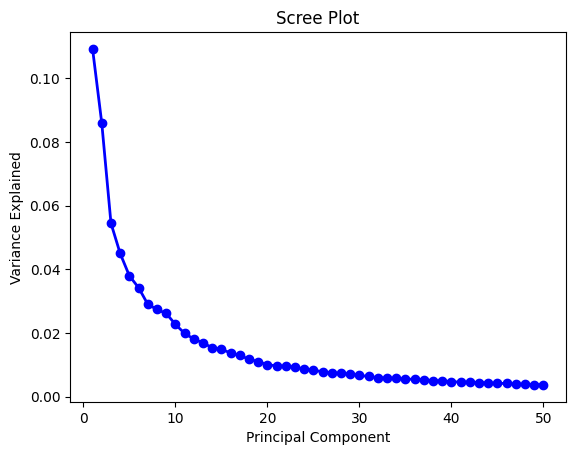

In [8]:
pca = PCA(n_components=200)
pca.fit(matriz)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(range(1,50 + 1), pca.explained_variance_ratio_[0:50], 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

El metodo del codo diria que tenemos que usar aproximadamente 7 componentes

## KMeans

In [ ]:
from sklearn.cluster import KMeans

inertia = []
kmax = 100

# entrenamiento y evaluación
for i in range(1,kmax + 1):
    # modelo
    kmeans = KMeans(n_clusters=i, n_init='auto')
    nCluster = kmeans.fit(X)

    print(i, nCluster.inertia_)
    inertia.append(nCluster.inertia_)

1 53.466351960263964
2 45.40456001292926
3 40.183821885754995
4 37.260434679944055
5 35.05497206335995
6 32.310047433888926
7 30.79212428571468
8 29.247162452008695
9 27.759907518815034
10 26.205948094758693
11 25.215684856536512
12 24.746063613886204
13 23.6317035096461
14 22.987601308616593
15 22.41166629931857
16 21.94205450668102
17 21.21136499956556
18 20.73551830246631
19 20.756369793619825
20 19.89611725209814
21 19.93636089524315
22 19.671126293865722
23 18.982532705853345
24 18.670679768832795
25 18.17079320497028
26 17.965090980977564
27 17.736311830097215
28 17.412510651308562
29 17.31788326280766
30 17.054811673253425
31 16.86063904519769
32 16.54891312914029
33 16.311112851300816
34 16.00979612884208
35 15.925835886216433
36 15.960424798572264
37 15.64056327226016
38 15.445563041631406
39 15.382603687398586
40 15.291534772503372
41 14.974696191985707
42 15.061723384942518
43 14.64980590911313
44 14.614390473821555
45 14.338930499733948
46 14.30671513539453
47 14.1473350312

Text(0.5, 1.0, 'K-means - Método del codo')

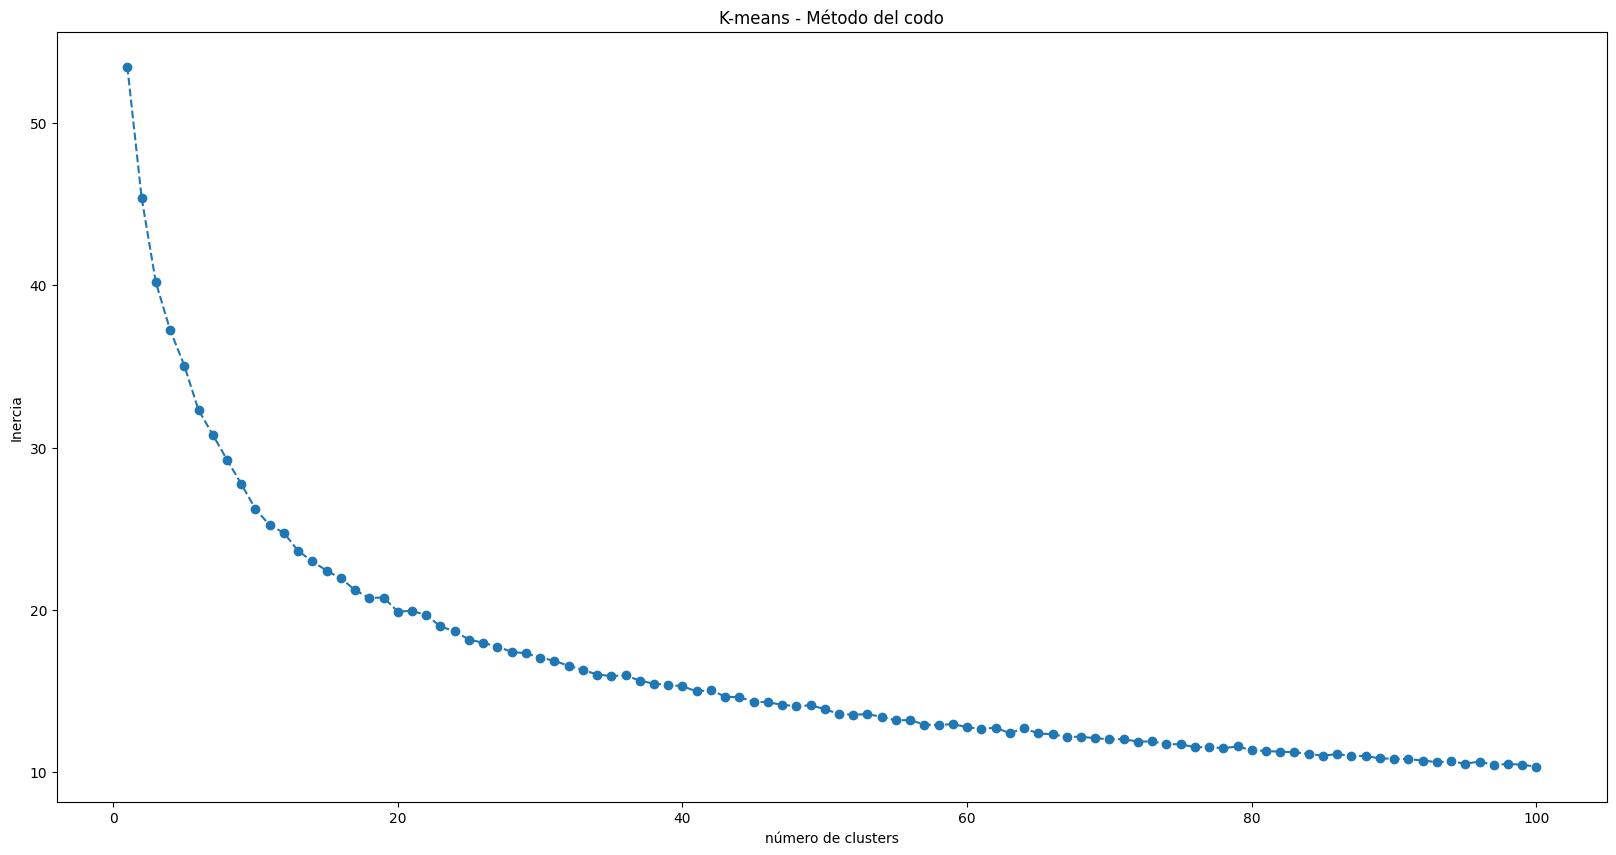

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

ax.plot(range(1, kmax + 1), inertia, marker='o', ls='--')
ax.set_xlabel('número de clusters')
ax.set_ylabel('Inercia')
ax.set_title('K-means - Método del codo')

Por metodo del codo unos 20 clusters tiene sentido

# Iteracion Rapida

In [6]:
cluster_df_normal = cluster_df.copy()

cluster_df_normal = cluster_df_normal.drop(columns=["Based on a Manga", "Original Work", "Based on a Light Novel"])
cluster_df_normal = cluster_df_normal[cluster_df.sum(axis=1) > 0]
cluster_df_normal = cluster_df_normal.sparse.to_dense()
cluster_df_normal = cluster_df_normal.div(cluster_df_normal.sum(axis=1), axis=0)
matriz = cluster_df_normal.to_numpy()

In [8]:
componentes = 3
grupos = 10

# pca = KernelPCA(n_components=componentes, kernel='rbf', gamma=0.1)
pca = PCA(n_components=componentes)

pca.fit(matriz)
X = pca.transform(matriz)

X_df = pd.DataFrame(X)
X_df.index = cluster_df_normal.index
X_df.columns = [f"PC{i}" for i in range(1, X_df.shape[1] + 1)]
X_df

kmeans = KMeans(n_clusters=grupos, n_init='auto')
kmeans.fit(X)
G = kmeans.predict(X)

X_df["grupo"] = G
cluster_df_normal["grupo"] = G
agrupado = cluster_df_normal.groupby("grupo").mean()

for index, grupo in agrupado.iterrows():
    print(f"{index}:\n{grupo.sort_values(ascending=False).head(10)}\n")

0:
Comedy                       0.068740
Fantasy                      0.059224
Action                       0.036748
School Life                  0.033754
Magic                        0.032107
Romance                      0.029352
Shounen                      0.028130
Adventure                    0.023742
Person in a Strange World    0.022077
Ecchi                        0.020450
Name: 0, dtype: float64

1:
Action                         0.062468
Fantasy                        0.051017
Violence                       0.039740
Shounen                        0.036741
Adventure                      0.030209
Comedy                         0.027087
Sci Fi                         0.020769
Magic                          0.020503
Drama                          0.020455
Overpowered Main Characters    0.020273
Name: 1, dtype: float64

2:
Drama            0.074251
Shounen          0.046649
School Life      0.040850
Action           0.036024
Romance          0.035066
Violence         0.033315
Matur

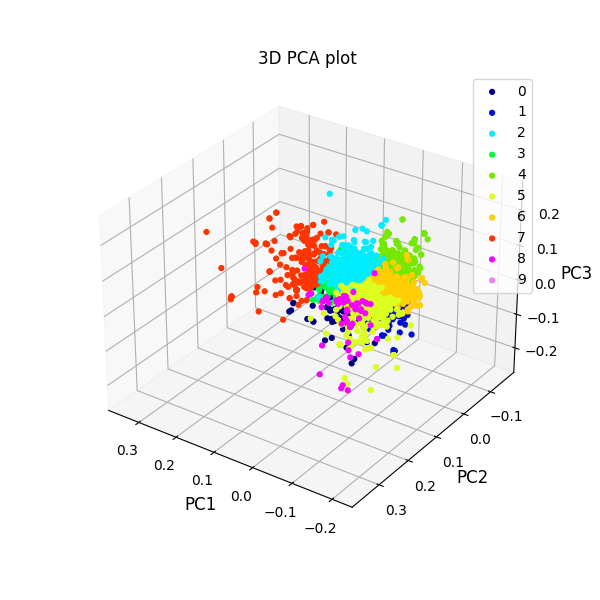

In [10]:
%matplotlib widget

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

Xax = X_df["PC1"]
Yax = X_df["PC2"]
Zax = X_df["PC3"]
Gax = X_df["grupo"]

norm=plt.Normalize(0, grupos) # El rango de valores para el colormap

for l in [x for x in range(0, grupos)]:
    ix = Gax == l
    ax.scatter(Xax[ix], Yax[ix], Zax[ix], cmap="gist_ncar", norm=norm, c=Gax[ix], alpha=1, s=12, label=l)

ax.set_xlabel("PC1", fontsize=12)
ax.set_ylabel("PC2", fontsize=12)
ax.set_zlabel("PC3", fontsize=12)
 
ax.view_init(30, 125)
ax.legend()
plt.title("3D PCA plot")
plt.show()

# Probar KMeans

In [34]:
from sklearn.cluster import KMeans

inertia = []
kmax = 100

# entrenamiento y evaluación
for i in range(1,kmax + 1):
    # modelo
    kmeans = KMeans(n_clusters=i, n_init='auto')
    nCluster = kmeans.fit(X)

    print(i, nCluster.inertia_)
    inertia.append(nCluster.inertia_)

1 53.466351960263964
2 45.40456001292926
3 40.183821885754995
4 37.260434679944055
5 35.05497206335995
6 32.310047433888926
7 30.79212428571468
8 29.247162452008695
9 27.759907518815034
10 26.205948094758693
11 25.215684856536512
12 24.746063613886204
13 23.6317035096461
14 22.987601308616593
15 22.41166629931857
16 21.94205450668102
17 21.21136499956556
18 20.73551830246631
19 20.756369793619825
20 19.89611725209814
21 19.93636089524315
22 19.671126293865722
23 18.982532705853345
24 18.670679768832795
25 18.17079320497028
26 17.965090980977564
27 17.736311830097215
28 17.412510651308562
29 17.31788326280766
30 17.054811673253425
31 16.86063904519769
32 16.54891312914029
33 16.311112851300816
34 16.00979612884208
35 15.925835886216433
36 15.960424798572264
37 15.64056327226016
38 15.445563041631406
39 15.382603687398586
40 15.291534772503372
41 14.974696191985707
42 15.061723384942518
43 14.64980590911313
44 14.614390473821555
45 14.338930499733948
46 14.30671513539453
47 14.1473350312

Text(0.5, 1.0, 'K-means - Método del codo')

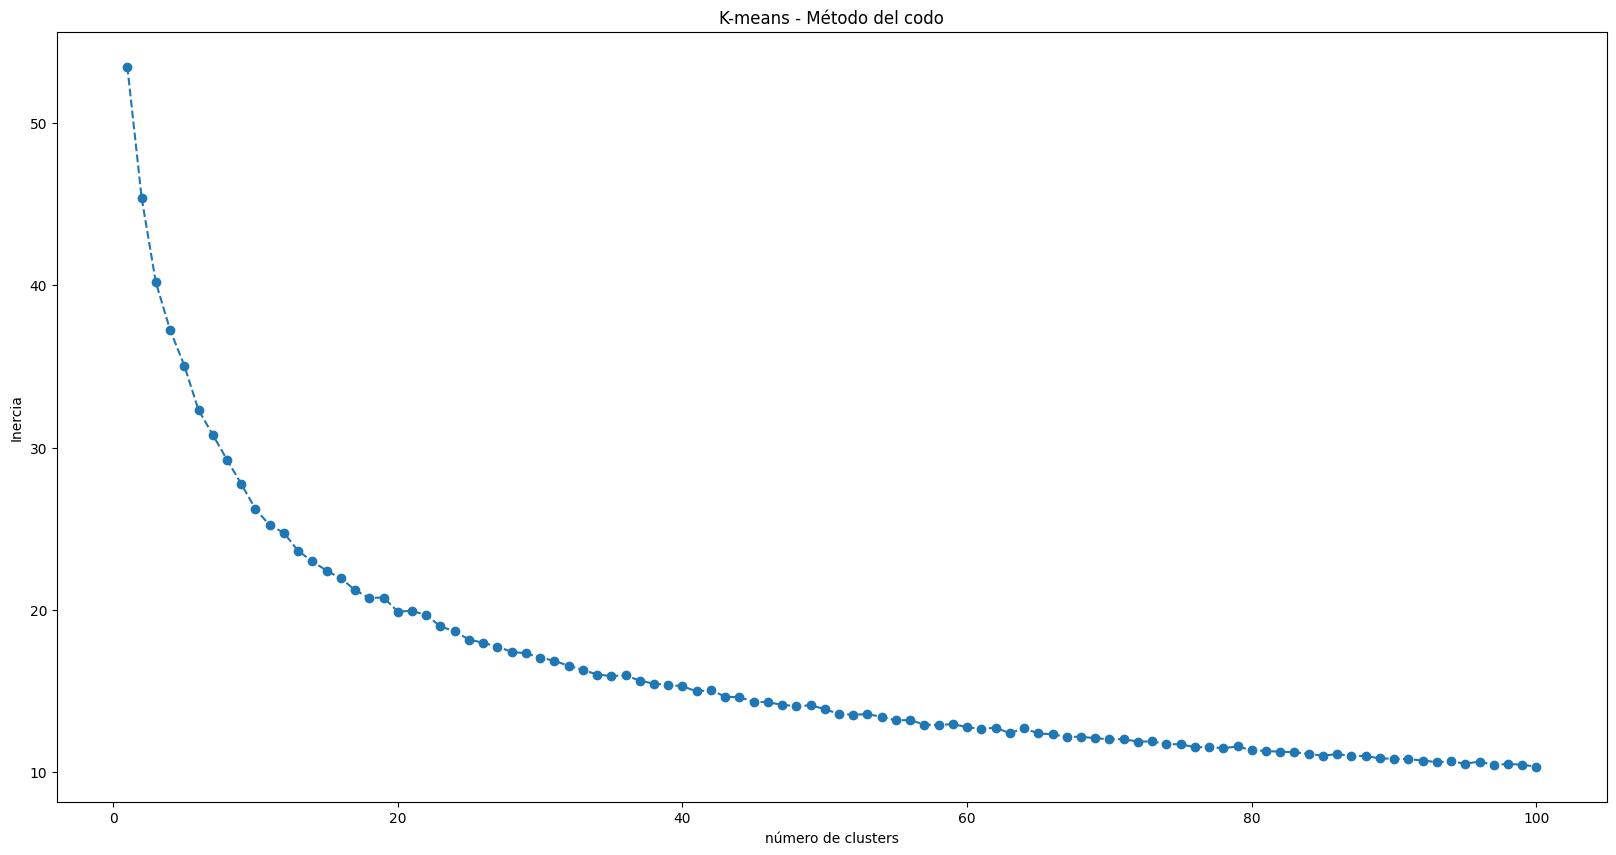

In [35]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

ax.plot(range(1, kmax + 1), inertia, marker='o', ls='--')
ax.set_xlabel('número de clusters')
ax.set_ylabel('Inercia')
ax.set_title('K-means - Método del codo')

Por metodo del codo unos 20 clusters tiene sentido